Data Preparation
* Data loading from data_train.json
* Basic features(user type, application time) processing and exploration
 * Application time ---- processed into day of week, time of the day.
 * Check the relationship between fraud and user type/appication time
* Sequential User behavior features processing and exploration
 * stay time, lag time between pages, time span of an application, page transitions overview.
* Processing data for model building
 * Sequential data padding
 * Standardization
 * Save in json format
* Generate Markov Transition Field along features. 
 * Zhang, R., Zheng, F., & Min, W. (2018). Sequential Behavioral Data Processing Using Deep Learning and the Markov Transition Field in Online Fraud Detection. arXiv preprint arXiv:1808.05329.
 * All features are bin and one-hot encoded into a binary vector.
 * matrix[i,j]  represents the probability that j=1 given i=1
* Generate Markov Transition Field along timesteps and Gramian Angular Field(code only)
 * Wang, Z., & Oates, T. (2015, April). Encoding time series as images for visual inspection and classification using tiled convolutional neural networks. In Workshops at the Twenty-Ninth AAAI Conference on Artificial Intelligence.

In [0]:
from datetime import datetime
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy import stats
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import os

data_dir = "../data/processed/"


# 1.Data loading

In [0]:
# change to raw data folder
# os.chdir(os.path.abspath(os.path.join(data_dir, "../../data/raw")))

In [0]:
%%time
sequential_data = []

line_number = 0
max_lines = 100
with open('../../data/raw/test_new.json', 'r') as f:
# with open('../../data/raw/data_train.json', 'r') as f:
    for line in f:
#         if len(sequential_data) > max_lines:
#             break
        sequential_data.append(json.loads(line))
# sequential_data = sequential_data[:100]
len(sequential_data)

Wall time: 1.15 s


30672

In [0]:
sequential_driver = {}

sequential_behavior = {}

for item in sequential_data:
    user_id = item[0]
    application_time = int(item[1]['order_info']['order_time'])
    sequential_driver.update({f"{user_id}|{application_time}": item[1]['order_info']})
    sub_data = [x for x in item[1]['data']
                if x['petime'] <= application_time-100]
    # we only keep data occurs before application time. "-100" is not neccessary for offline data cleaning.
    # but sometimes we use this trick for online calculation to avoid network slowdown
    sequential_behavior.update({f"{user_id}|{application_time}": sub_data})
# sequential_driver

# 2.Basic features processing and exploration 


#### 2.1 Processing
- Converting unix time to real time
- Extract application day of week and time of the day from feature "application_date"
- Divide time of the day into 6 catogories: 0:00-4:00,4:00-8:00,8:00-12:00,12:00-16:00,16:00-20:00,20:00-24:00

In [0]:
driver = pd.DataFrame(sequential_driver).T.reset_index()
driver['user_id'] = driver['index'].apply(lambda x : x.split('|')[0])
driver['application_time'] = driver['index'].apply(lambda x : x.split('|')[1])
# driver[driver['new_client']==0.0]["user_id"].value_counts().value_counts()

In [0]:
driver['application_date'] = pd.to_datetime(driver['order_time'],unit='ms')
driver["day_of_week"]=(driver["application_date"].dt.dayofweek+1).astype(str) 
driver["hour_of_day"]=(driver["application_date"].dt.hour//4+1).astype(str) 
driver=driver.join(pd.get_dummies(driver["day_of_week"]))
driver=driver.join(pd.get_dummies(driver["hour_of_day"]),rsuffix="_time")


# 3. User behaviour sequence exploration and processing

## 3.1 sequential_behavior

In [0]:
behavior = []
for user_keys in sequential_behavior:    
    user_id, application_time = user_keys.split("|")
    index=user_keys
    for item in sequential_behavior[user_keys]:    
        subitem = item.copy()
        subitem.update({"user_id":user_id, "application_time":application_time,"index":index})
        behavior.append(subitem)
behavior = pd.DataFrame(behavior)
behavior = behavior.sort_values(['user_id', 'application_time', 'petime'])
behavior.shape, behavior.user_id.nunique(),behavior["index"].nunique()

((638034, 8), 16465, 19617)

In [0]:
# behavior[40:70]
#  process id `pid` : as long as the app is open, pid will be the same, no matter whether it's running or hanging in the background. It will be reset if the app is killed.
# session id `sid` : every time when an app is recovered from background, sid will be reset.
behavior.groupby(["index"]).head(5).head(60).reset_index()[["pname","index","stay_time"]].merge(driver[["index", "label"]], how="left")

,pname,index,stay_time,label
0,login,00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,13.382,0.0
1,loan_index,00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,3.584,0.0
2,operator,00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,21.570,0.0
3,operator,00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,9.653,0.0
4,loan_index,00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,20.004,0.0
5,bind_debit_card,0006e4f012fd4cb7b37cb18a84bbc79b|1509324360000,1.555,0.0
6,loan_index,0006e4f012fd4cb7b37cb18a84bbc79b|1509324360000,6.310,0.0
7,loan_submission,0006e4f012fd4cb7b37cb18a84bbc79b|1509324360000,15.442,0.0
8,loan_index,0006e4f012fd4cb7b37cb18a84bbc79b|1509324360000,2.786,0.0
9,loan_index,0006e4f012fd4cb7b37cb18a84bbc79b|1509324360000,1.887,0.0


In [0]:
behavior[behavior["stay_time"]>1].groupby(["index"]).count().reset_index()[["pname","index","stay_time"]].merge(driver[["index", "label"]], how="left")

,pname,index,stay_time,label
0,20,00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,20,0.0
1,15,0006e4f012fd4cb7b37cb18a84bbc79b|1509324360000,15,0.0
2,27,000e85df3eb94068bbb379e127e91f9a|1508202300000,27,0.0
3,32,000e85df3eb94068bbb379e127e91f9a|1509433020000,32,1.0
4,49,000f0689178848dba819e601c2ca2f4c|1507785480000,49,0.0
...,...,...,...,...
19579,31,fffbd399e5d1481aa52cffc2c5e70cc8|1506897480000,31,0.0
19580,30,fffca13469f845a7b9ae8dc1f52dffde|1507150980000,30,0.0
19581,34,fffca13469f845a7b9ae8dc1f52dffde|1508359020000,34,0.0
19582,6,fffd06b3116a496a95f8a6b9f27b9732|1508628780000,6,1.0


In [0]:
behavior_count = behavior.groupby(["index"]).count()[["user_id"]].reset_index()
behavior_count.rename(columns={'user_id': 'count'}, inplace=True)
behavior = behavior.merge(behavior_count, how="left")

(array([  0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   2.,   2.,
          2.,   2.,   6.,  11., 107., 137., 280., 339., 361., 834., 467.,
        493., 520., 486., 963., 461., 439., 425., 443., 778., 334., 338.,
        318., 302., 516., 243., 240., 223., 199., 348., 152., 147., 143.,
        133., 218.,  94.,  80.,  97., 162.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
        13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. , 25.2,
        26.4, 27.6, 28.8, 30. , 31.2, 32.4, 33.6, 34.8, 36. , 37.2, 38.4,
        39.6, 40.8, 42. , 43.2, 44.4, 45.6, 46.8, 48. , 49.2, 50.4, 51.6,
        52.8, 54. , 55.2, 56.4, 57.6, 58.8, 60. ]),
 <a list of 50 Patch objects>)

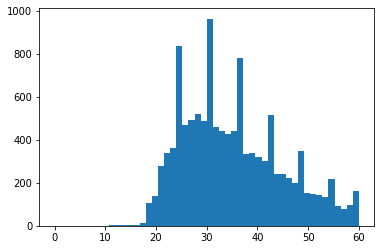

In [0]:
behavior_above_20 = behavior[behavior["count"]>20]
plt.hist(behavior_above_20[behavior_above_20["stay_time"]>1].groupby(["index"]).count()["user_id"], bins=50, range=(0, 60))

,index,label
0,0ed9672fa61f4d6da241a6289000e2f2|1507102200000,0.0
1,48b72ca5b43248d3b50dfadb76c651a2|1508810700000,0.0
2,8e669f481a4645c89de0f29f980522e9|1508354520000,0.0
3,d9a86017a67140ab96d9c405d1ebb02d|1507129920000,0.0
4,96e3ded73e6b47ba91108e5b6a923c81|1509348180000,0.0
...,...,...
30667,181cacbea46b40f9a274aa967b62c5ed|1507265100000,1.0
30668,c7b1e921ebb541bea7b7073c35bccaa0|1509245280000,0.0
30669,e61b2a2e4b6e476ca8b45ef214ed1ab0|1506968760000,1.0
30670,4ea58b1cc0784613807cc738dbf7321e|1509073080000,0.0


## 3.2 Distribution of page stay time

In [0]:
behavior["stay_time"]=(behavior["petime"]-behavior["pstime"])/1000
behavior[behavior["stay_time"]>0]["stay_time"].describe()

count    6.371780e+05
mean     4.271703e+01
std      3.415354e+03
min      1.300000e-02
25%      1.919000e+00
50%      4.483000e+00
75%      1.121700e+01
max      2.588394e+06
Name: stay_time, dtype: float64

- Page stay time has some outliers and is right-skewed, we want to delete the outliers and take the logarithm of the stay time.

## 3.3 Distribution of  lag time between pages

In [0]:
behavior = behavior.assign(lagg=lambda x: np.where(x.user_id.shift(1) == x.user_id, (x.pstime-x.petime.shift(1))/1000, 0))
behavior[behavior["lagg"] >= 14400].groupby("index").count()[["lagg"]]

,lagg
index,
00060e8ebf674d3ba77df5bcb80e8f8e|1507164000000,2
000e85df3eb94068bbb379e127e91f9a|1509433020000,1
000f0689178848dba819e601c2ca2f4c|1507785480000,5
000f0689178848dba819e601c2ca2f4c|1508895720000,7
00101e1ec08e4f1980b269e4078b309d|1508032680000,2
...,...
fff74b0291224857a1c701b2e4b7e5a6|1508238060000,4
fffbd399e5d1481aa52cffc2c5e70cc8|1506897480000,1
fffca13469f845a7b9ae8dc1f52dffde|1507150980000,3


- The lag time between pages have a large variation, as most applications takes days to complete
- It is also right-skewed, so we take the logarithm of the lag time.

## 3.4 Explore the duration(time span) of an application

In [0]:
duration_dic = {}
for key, value in sequential_behavior.items():
    # print(value)
    value.sort(key=lambda x: x['petime'])
    if len(value) < 2:
        continue
    start_time = pd.to_datetime(value[0]["pstime"], unit='ms')
    end_time = pd.to_datetime(value[-1]["petime"], unit='ms')
    duration = end_time-start_time
    duration_dic[key] = duration

In [0]:
test = pd.DataFrame(duration_dic, index=[0]).T.reset_index()
test = test.rename(columns={"index": "unique_id", 0: "duration"})

KeyboardInterrupt: 

In [0]:
test = test.merge(driver, left_on="unique_id", right_on="index", how="inner")
test.head()

In [0]:
# test["duration_day"] = test["duration"]/np.timedelta64(1, 'D')
# test = test[test["duration_day"] >= 0]

# cross_table = pd.crosstab(test["label"], test["duration_day"], margins=True)
# print('chisq = %6.4f\n p-value = %6.4f\n dof = %i\n expected_freq =\n %s' % stats.chi2_contingency(cross_table))

- No significatn difference in application's time span between benign users and fraud users is observed